# Autoencoder for uninfected malaria cell images

## Imports

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D, LeakyReLU
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Data Preparation

In [2]:
BASE_PATH = "/Users/simoneboesso/Desktop/nuclei-segmentation/cell_images/Uninfected"
SIZE  = 32

## Data Loading

In [3]:
''' It returns:
Since the Folders with the images have the following structure:
- ROOT
-- Parasitized
-- Uninfected
I need to construct the corrisponding label
'''
images_dir_path = '/Users/simoneboesso/Desktop/nuclei-segmentation/cell_images'  
images_dirs_paths = [name for name in os.listdir(images_dir_path) if name != '.DS_Store']
image_paths = []
image_classes = []
class_id = 0

def imglist(path_dir):    
    return [os.path.join(path_dir, image) for image in os.listdir(path_dir)]

''' It returns:
- image_paths: list of paths to all the images
- image_classes: list of labels
'''
for images_dir in images_dirs_paths:
    if images_dir  == "Parasitized":
        class_id = 1
    else:
        class_id = 0
    sub_dir = os.path.join(images_dir_path, images_dir)
    class_path = imglist(sub_dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [4]:
sum(np.array(image_classes)==1)

13780

In [5]:
sum(np.array(image_classes)==0)

13780

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras
import random
import pandas as pd
import tensorflow

In [7]:
import cv2
from PIL import Image
import numpy as np
from skimage.restoration import denoise_nl_means, estimate_sigma
image_data = []
labels = []

index = 0


for image_path in image_paths:
    if '.png' in image_path:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        if image is not None:
            # Resize the image to 32x32
            normalized_image = np.array(image) / 255.0  # Normalize the image data
            resized_image = cv2.resize(normalized_image, (SIZE, SIZE))

            image_data.append(resized_image)
            labels.append(image_classes[index])
        else:
            print(f"Image {image_path} could not be loaded")
    else:
        print(f"Image {image_path} is not a PNG file")
    index += 1


Image /Users/simoneboesso/Desktop/nuclei-segmentation/cell_images/Parasitized/Thumbs.db is not a PNG file
Image /Users/simoneboesso/Desktop/nuclei-segmentation/cell_images/Uninfected/Thumbs.db is not a PNG file


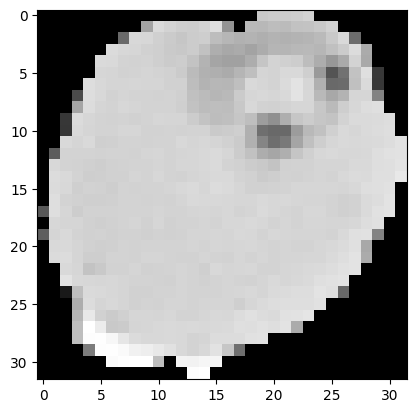

In [8]:
plt.imshow(image_data[0],cmap="gray")

In [9]:
labels[0]

1

In [10]:
type(image_data[0])

numpy.ndarray

In [11]:
image_data[0].max()

0.7289828431372548

In [12]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(np.array(image_data), np.array(labels), test_size = 0.20, random_state = 0)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(np.array(X_train), np.array(y_train), test_size = 0.20, random_state = 0)

In [14]:
mask = (y_train==0)
X_train = X_train[mask]

In [15]:
X_train.shape

(8779, 32, 32)

In [16]:
mask = (y_val==0)
X_val_healthy = X_val[mask]

## Model Creation

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation
from keras.layers import Reshape, Flatten
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization

input_shape = (SIZE, SIZE, 1)  # Replace with actual input image dimensions

# Encoder
input_img = Input(shape=input_shape)
x = Conv2D(4, (3, 3), padding='same', activation='relu')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# Decoder
x = Conv2DTranspose(32, (2, 2), strides=2, activation='relu', padding='same')(encoded)
x = Conv2DTranspose(14, (2, 2), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(4, (2, 2), strides=2, activation='relu', padding='same')(x)
decoded = Conv2DTranspose(1, (2,2), strides=1, activation='sigmoid', padding='same')(x)  

autoencoder = Model(input_img, decoded)

autoencoder.summary()



# Compile the model with an initial learning rate
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss="MSE")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 32)       │         4,128 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 14)     │         1,806 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 4)      │           228 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 1)      │            17 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

### Model compilation

In [19]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('Autoencoder_for_Denoising.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_loss') ]

In [ ]:
## Allenare per 200 epochs lasciando a 32 la size!
## Aggiungere Batch norm!

In [20]:
import tensorflow
import numpy as np
#Fit the model
history = autoencoder.fit(np.array(X_train), 
                         X_train, 
                         batch_size = 128, 
                         verbose = 1, 
                         epochs = 200,      
                          validation_data=(X_val_healthy , X_val_healthy ),
                         shuffle = False,
                        callbacks= callbacks
                     )

Epoch 1/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0521 - val_loss: 0.0111
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0104 - val_loss: 0.0087
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 10/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 11/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 12/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

## Finding the best threshold using the validation set with also the Parasitized cells

In [38]:
from sklearn.metrics import precision_recall_curve

reconstructed_X = autoencoder.predict(X_val)
reconstructed_X = np.squeeze(reconstructed_X)
mse = np.mean(np.power(X_val - reconstructed_X, 2), axis=(1,2))

# Assuming y_test2 is your true labels and mse is the predicted scores/probabilities
precision, recall, thresholds = precision_recall_curve(y_val, mse)
# F1 = 2 * (precision * recall) / (precision + recall)
f1_scores = 2 * (precision * recall) / (precision + recall)
index = np.argmax(f1_scores)
threshold = thresholds[index]
threshold = round(threshold,5)
threshold

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.00181

### Model Loss over Epochs

Here the validation loss is computed with a subset withou Parasited cells

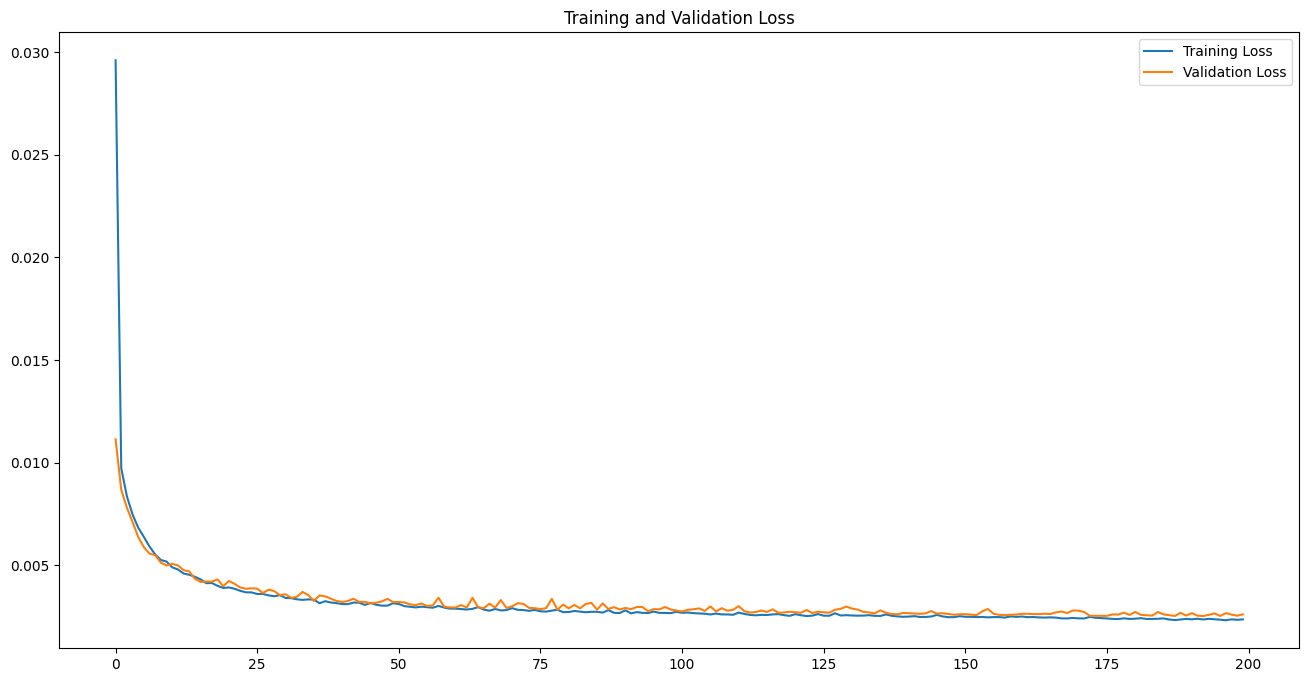

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

reconstructed_X = autoencoder.predict(X_test)
reconstructed_X = np.squeeze(reconstructed_X)
mse = np.mean(np.power(X_test - reconstructed_X, 2), axis=(1,2))
print("the threshold found th is ",threshold)
predictions = (mse > threshold).astype(int)



# Assuming y_test2 contains the true labels and predictions contains the predicted labels
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)  # Use 'binary' for binary classification
recall = recall_score(y_test, predictions)  # Use 'binary' for binary classification

# Print the results
print(f"Accuracy: {round(accuracy,3)}")
print(f"Precision: {round(precision,3)}")
print("recall",round(recall,3))

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
the threshold found th is  0.00181
Accuracy: 0.71
Precision: 0.643
recall 0.921


# ROC Curve

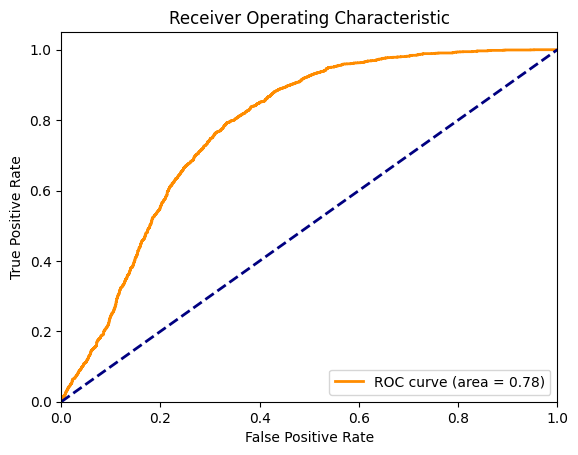

In [36]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()